In [6]:
import rlcard
from rlcard.agents import DQNAgent
from rlcard.utils import set_seed, tournament
import numpy as np
import torch
import optuna
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


In [7]:
set_seed(24)

env = rlcard.make("blackjack")
eval_env = rlcard.make("blackjack")

print("Number of actions:", env.num_actions)
print("Number of players:", env.num_players)
print("Shape of state:", env.state_shape)
print("Shape of action:", env.action_shape)

Number of actions: 2
Number of players: 1
Shape of state: [[2]]
Shape of action: [None]


In [8]:
def objective(trial):
    """
    Objective function for Optuna optimization
    """
    # Create fresh environments for each trial
    env = rlcard.make("blackjack")
    eval_env = rlcard.make("blackjack")
    
    # Set seed for reproducibility within trial
    set_seed(trial.number + 42)
    
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    epsilon_decay_steps = trial.suggest_int('epsilon_decay_steps', 3000, 25000)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    
    # Network architecture
    network_choice = trial.suggest_categorical('network_choice', [
        'small', 'medium', 'large', 'deep'
    ])
    
    network_configs = {
        'small': [64, 64],
        'medium': [128, 128], 
        'large': [256, 128],
        'deep': [64, 128, 64]
    }
    mlp_layers = network_configs[network_choice]
    
    # Additional hyperparameters
    replay_memory_size = trial.suggest_categorical('replay_memory_size', [10000, 20000, 50000])
    train_every = trial.suggest_int('train_every', 1, 4)
    
    # Create DQN agent with suggested parameters
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    try:
        agent = DQNAgent(
            num_actions=env.num_actions,
            state_shape=env.state_shape[0],
            mlp_layers=mlp_layers,
            learning_rate=learning_rate,
            epsilon_decay_steps=epsilon_decay_steps,
            batch_size=batch_size,
            replay_memory_size=replay_memory_size,
            replay_memory_init_size=max(batch_size * 3, 1000),  # Ensure enough initial experiences
            train_every=train_every,
            device=device,
        )
    except Exception as e:
        print(f"Error creating agent: {e}")
        return -1.0  # Return bad score for invalid configs
    
    # Training parameters
    num_episodes = 4000  # Reduced for faster trials
    eval_freq = 1000
    eval_games = 500
    
    best_performance = -float('inf')
    
    print(f"Trial {trial.number}: LR={learning_rate:.1e}, "
          f"EPS_DECAY={epsilon_decay_steps}, BATCH={batch_size}, "
          f"NET={network_choice}")
    
    # Training loop
    for episode in range(num_episodes):
        # Training step
        state, player_id = env.reset()
        
        while not env.is_over():
            action = agent.step(state)
            next_state, next_player_id = env.step(action)
            
            if env.is_over():
                payoffs = env.get_payoffs()
                reward = payoffs[0]
                done = True
            else:
                reward = 0
                done = False
            
            agent.feed((state, action, reward, next_state, done))
            state = next_state
            player_id = next_player_id
        
        # Evaluation
        if episode % eval_freq == 0:
            eval_rewards = []
            for _ in range(eval_games):
                eval_state, eval_player_id = eval_env.reset()
                
                while not eval_env.is_over():
                    action, _ = agent.eval_step(eval_state)
                    eval_state, eval_player_id = eval_env.step(action)
                
                payoffs = eval_env.get_payoffs()
                eval_rewards.append(payoffs[0])
            
            avg_reward = np.mean(eval_rewards)
            
            if avg_reward > best_performance:
                best_performance = avg_reward
            
            print(f"  Episode {episode}: {avg_reward:.3f} (best: {best_performance:.3f})")
            
            # Report intermediate value to Optuna for pruning
            trial.report(avg_reward, episode)
            
            # Handle pruning based on the intermediate value
            if trial.should_prune():
                print(f"  Trial {trial.number} pruned at episode {episode}")
                raise optuna.exceptions.TrialPruned()
    
    print(f"Trial {trial.number} completed with best performance: {best_performance:.3f}")
    return best_performance

print("Objective function defined!")


Objective function defined!


In [9]:
# Create study with pruning for efficiency
study = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=2000,
        interval_steps=1000
    )
)

print("Optuna study created with median pruning!")
print("Study configuration:")
print(f"  Direction: {study.direction}")
print(f"  Pruner: {type(study.pruner).__name__}")

[I 2025-06-25 20:25:04,258] A new study created in memory with name: no-name-a1085967-6d89-47c6-b575-342f31738188


Optuna study created with median pruning!
Study configuration:
  Direction: 2
  Pruner: MedianPruner


In [10]:
N_TRIALS = 20

try:
    study.optimize(objective, n_trials=N_TRIALS, timeout=7200)  # 2 hour timeout
except KeyboardInterrupt:
    print("\nOptimization interrupted by user")

print(f"End time: {datetime.now().strftime('%H:%M:%S')}")
print("Optimization completed!")

# Cell 6: Display Results
print("\n" + "=" * 60)
print("OPTIMIZATION RESULTS")
print("=" * 60)

print(f"Number of finished trials: {len(study.trials)}")
print(f"Number of pruned trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
print(f"Number of complete trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")

if study.best_trial:
    print(f"\nBest trial: {study.best_trial.number}")
    print(f"Best performance: {study.best_value:.4f}")
    print("\nBest parameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
else:
    print("No best trial found")

# Cell 7: Analyze Results and Create Visualizations
# Get completed trials
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

if complete_trials:
    # Create DataFrame for analysis
    data = []
    for trial in complete_trials:
        row = trial.params.copy()
        row['performance'] = trial.value
        row['trial_number'] = trial.number
        data.append(row)
    
    df = pd.DataFrame(data)
    
    print("\nPerformance Statistics:")
    print(f"  Mean: {df['performance'].mean():.4f}")
    print(f"  Std:  {df['performance'].std():.4f}")
    print(f"  Min:  {df['performance'].min():.4f}")
    print(f"  Max:  {df['performance'].max():.4f}")
    
    # Parameter importance (if enough trials)
    if len(complete_trials) >= 10:
        try:
            importance = optuna.importance.get_param_importances(study)
            print(f"\nParameter Importance:")
            for param, imp in sorted(importance.items(), key=lambda x: x[1], reverse=True):
                print(f"  {param}: {imp:.3f}")
        except:
            print("\nCould not calculate parameter importance")
    
    print(f"\nResults stored in DataFrame 'df' with {len(df)} trials")
else:
    print("No completed trials to analyze")

Trial 0: LR=8.6e-03, EPS_DECAY=20045, BATCH=16, NET=medium
  Episode 0: -1.000 (best: -1.000)
INFO - Step 1000, rl-loss: 2.8451457023620605
INFO - Copied model parameters to target network.
INFO - Step 1376, rl-loss: 1.46867465972900467  Episode 1000: -0.100 (best: -0.100)
INFO - Step 2000, rl-loss: 0.73630702495574954
INFO - Copied model parameters to target network.
INFO - Step 2767, rl-loss: 0.38038593530654915  Episode 2000: -0.124 (best: -0.100)
INFO - Step 3000, rl-loss: 0.84042334556579597
INFO - Copied model parameters to target network.
INFO - Step 4000, rl-loss: 0.52339619398117075
INFO - Copied model parameters to target network.
INFO - Step 4145, rl-loss: 0.46109491586685183  Episode 3000: -0.164 (best: -0.100)
INFO - Step 5000, rl-loss: 0.33194029331207275
INFO - Copied model parameters to target network.
INFO - Step 5559, rl-loss: 0.85178136825561523

[I 2025-06-25 20:26:03,292] Trial 0 finished with value: -0.1 and parameters: {'learning_rate': 0.0086085815072197, 'epsilon_decay_steps': 20045, 'batch_size': 16, 'network_choice': 'medium', 'replay_memory_size': 10000, 'train_every': 1}. Best is trial 0 with value: -0.1.


INFO - Step 5576, rl-loss: 0.47626006603240967Trial 0 completed with best performance: -0.100
Trial 1: LR=2.0e-04, EPS_DECAY=22853, BATCH=64, NET=small
  Episode 0: -0.148 (best: -0.148)
INFO - Step 1000, rl-loss: 1.5355291366577148
INFO - Copied model parameters to target network.
INFO - Step 1346, rl-loss: 0.8111640810966492  Episode 1000: -0.038 (best: -0.038)
INFO - Step 2714, rl-loss: 0.69529438018798835  Episode 2000: -0.144 (best: -0.038)
INFO - Step 3000, rl-loss: 0.5511331558227539
INFO - Copied model parameters to target network.
INFO - Step 4096, rl-loss: 0.48335313796997076  Episode 3000: -0.016 (best: -0.016)
INFO - Step 5000, rl-loss: 0.34469652175903326
INFO - Copied model parameters to target network.
INFO - Step 5482, rl-loss: 0.49519425630569464

[I 2025-06-25 20:26:44,088] Trial 1 finished with value: -0.016 and parameters: {'learning_rate': 0.00020248763624924765, 'epsilon_decay_steps': 22853, 'batch_size': 64, 'network_choice': 'small', 'replay_memory_size': 50000, 'train_every': 2}. Best is trial 1 with value: -0.016.


INFO - Step 5504, rl-loss: 0.46257591247558594Trial 1 completed with best performance: -0.016
Trial 2: LR=1.8e-04, EPS_DECAY=16413, BATCH=128, NET=large
  Episode 0: -0.196 (best: -0.196)
INFO - Step 1000, rl-loss: 1.3948252201080322
INFO - Copied model parameters to target network.
INFO - Step 1383, rl-loss: 0.44187304377555847  Episode 1000: -0.102 (best: -0.102)
INFO - Step 2000, rl-loss: 0.37037897109985356
INFO - Copied model parameters to target network.
INFO - Step 2757, rl-loss: 0.50842809677124026  Episode 2000: -0.104 (best: -0.102)
INFO - Step 3000, rl-loss: 0.61092621088027953
INFO - Copied model parameters to target network.
INFO - Step 4000, rl-loss: 0.58383297920227056
INFO - Copied model parameters to target network.
INFO - Step 4157, rl-loss: 0.50435674190521244  Episode 3000: -0.130 (best: -0.102)
INFO - Step 5000, rl-loss: 0.57117962837219246
INFO - Copied model parameters to target network.
INFO - Step 5580, rl-loss: 0.62905633449554446

[I 2025-06-25 20:27:47,757] Trial 2 finished with value: -0.102 and parameters: {'learning_rate': 0.0001846152571638271, 'epsilon_decay_steps': 16413, 'batch_size': 128, 'network_choice': 'large', 'replay_memory_size': 20000, 'train_every': 1}. Best is trial 1 with value: -0.016.


INFO - Step 5581, rl-loss: 0.608362078666687Trial 2 completed with best performance: -0.102
Trial 3: LR=3.3e-04, EPS_DECAY=16615, BATCH=128, NET=small
  Episode 0: -0.904 (best: -0.904)
INFO - Step 1000, rl-loss: 0.8487246036529541
INFO - Copied model parameters to target network.
INFO - Step 1416, rl-loss: 0.54834508895874024  Episode 1000: -0.048 (best: -0.048)
INFO - Step 2784, rl-loss: 0.42898669838905334  Episode 2000: -0.122 (best: -0.048)
INFO - Step 4176, rl-loss: 0.45456755161285467  Episode 3000: -0.004 (best: -0.004)
INFO - Step 5000, rl-loss: 0.48438426852226266
INFO - Copied model parameters to target network.
INFO - Step 5524, rl-loss: 0.56747406721115114

[I 2025-06-25 20:28:14,817] Trial 3 finished with value: -0.004 and parameters: {'learning_rate': 0.0003285861887545055, 'epsilon_decay_steps': 16615, 'batch_size': 128, 'network_choice': 'small', 'replay_memory_size': 20000, 'train_every': 4}. Best is trial 3 with value: -0.004.


INFO - Step 5548, rl-loss: 0.4912911355495453Trial 3 completed with best performance: -0.004
Trial 4: LR=1.2e-04, EPS_DECAY=9660, BATCH=16, NET=deep
  Episode 0: -0.332 (best: -0.332)
INFO - Step 1000, rl-loss: 0.8073354959487915
INFO - Copied model parameters to target network.
INFO - Step 1369, rl-loss: 0.38214772939682007  Episode 1000: -0.134 (best: -0.134)
INFO - Step 2000, rl-loss: 0.33040171861648567
INFO - Copied model parameters to target network.
INFO - Step 2727, rl-loss: 0.33383876085281376  Episode 2000: -0.046 (best: -0.046)
INFO - Step 3000, rl-loss: 0.37364679574966437
INFO - Copied model parameters to target network.
INFO - Step 4000, rl-loss: 0.46521016955375676
INFO - Copied model parameters to target network.
INFO - Step 4138, rl-loss: 0.64899349212646484  Episode 3000: -0.002 (best: -0.002)
INFO - Step 5000, rl-loss: 0.48093551397323613
INFO - Copied model parameters to target network.
INFO - Step 5593, rl-loss: 0.34524554014205935

[I 2025-06-25 20:29:11,669] Trial 4 finished with value: -0.002 and parameters: {'learning_rate': 0.00012460404225080648, 'epsilon_decay_steps': 9660, 'batch_size': 16, 'network_choice': 'deep', 'replay_memory_size': 50000, 'train_every': 1}. Best is trial 4 with value: -0.002.


INFO - Step 5600, rl-loss: 0.4520699381828308Trial 4 completed with best performance: -0.002
Trial 5: LR=2.4e-03, EPS_DECAY=19892, BATCH=64, NET=deep
  Episode 0: -0.396 (best: -0.396)
INFO - Step 1000, rl-loss: 1.4546804428100586
INFO - Copied model parameters to target network.
INFO - Step 1348, rl-loss: 0.7308804988861084  Episode 1000: -0.098 (best: -0.098)
INFO - Step 2756, rl-loss: 0.8238158822059631  Episode 2000: -0.070 (best: -0.070)
INFO - Step 4212, rl-loss: 0.6085336208343506

[I 2025-06-25 20:29:33,524] Trial 5 pruned. 


  Episode 3000: -0.086 (best: -0.070)
  Trial 5 pruned at episode 3000
Trial 6: LR=2.4e-03, EPS_DECAY=12537, BATCH=16, NET=small
  Episode 0: -0.208 (best: -0.208)
INFO - Step 1000, rl-loss: 0.8660287261009216
INFO - Copied model parameters to target network.
INFO - Step 1342, rl-loss: 0.56171518564224246  Episode 1000: -0.050 (best: -0.050)
INFO - Step 2713, rl-loss: 0.70985716581344614  Episode 2000: -0.120 (best: -0.050)
INFO - Step 4000, rl-loss: 0.95465266704559335
INFO - Copied model parameters to target network.
INFO - Step 4150, rl-loss: 0.55732768774032593

[I 2025-06-25 20:29:55,082] Trial 6 pruned. 


  Episode 3000: -0.086 (best: -0.050)
  Trial 6 pruned at episode 3000
Trial 7: LR=3.9e-05, EPS_DECAY=12531, BATCH=128, NET=deep
  Episode 0: -0.402 (best: -0.402)
INFO - Step 1000, rl-loss: 0.7701641321182251
INFO - Copied model parameters to target network.
INFO - Step 1354, rl-loss: 0.36010023951530457  Episode 1000: -0.118 (best: -0.118)
INFO - Step 2706, rl-loss: 0.31147563457489014  Episode 2000: -0.182 (best: -0.118)
INFO - Step 3000, rl-loss: 0.35733073949813844
INFO - Copied model parameters to target network.
INFO - Step 4114, rl-loss: 0.56591439247131357

[I 2025-06-25 20:30:22,998] Trial 7 pruned. 


  Episode 3000: -0.080 (best: -0.080)
  Trial 7 pruned at episode 3000
Trial 8: LR=1.8e-05, EPS_DECAY=13553, BATCH=128, NET=large
  Episode 0: -1.000 (best: -1.000)
INFO - Step 1000, rl-loss: 0.6264630556106567
INFO - Copied model parameters to target network.
INFO - Step 1376, rl-loss: 0.41653448343276983  Episode 1000: -0.086 (best: -0.086)
INFO - Step 2000, rl-loss: 0.40960478782653815
INFO - Copied model parameters to target network.
INFO - Step 2744, rl-loss: 0.47164282202720646  Episode 2000: -0.044 (best: -0.044)
INFO - Step 3000, rl-loss: 0.55274784564971925
INFO - Copied model parameters to target network.
INFO - Step 4000, rl-loss: 0.52509438991546636
INFO - Copied model parameters to target network.
INFO - Step 4101, rl-loss: 0.48699986934661865

[I 2025-06-25 20:31:02,335] Trial 8 pruned. 


  Episode 3000: -0.150 (best: -0.044)
  Trial 8 pruned at episode 3000
Trial 9: LR=1.1e-04, EPS_DECAY=11868, BATCH=32, NET=deep
  Episode 0: -0.262 (best: -0.262)
INFO - Step 1000, rl-loss: 1.148982048034668
INFO - Copied model parameters to target network.
INFO - Step 1345, rl-loss: 0.41143125295639045  Episode 1000: -0.084 (best: -0.084)
INFO - Step 2719, rl-loss: 0.42143481969833374  Episode 2000: -0.096 (best: -0.084)
INFO - Step 4000, rl-loss: 0.39637488126754763
INFO - Copied model parameters to target network.
INFO - Step 4078, rl-loss: 0.55275475978851324

[I 2025-06-25 20:31:30,992] Trial 9 pruned. 


  Episode 3000: -0.062 (best: -0.062)
  Trial 9 pruned at episode 3000
Trial 10: LR=6.3e-04, EPS_DECAY=3274, BATCH=16, NET=medium
  Episode 0: -0.136 (best: -0.136)
INFO - Step 1000, rl-loss: 0.8744635581970215
INFO - Copied model parameters to target network.
INFO - Step 1360, rl-loss: 0.93232065439224247  Episode 1000: -0.090 (best: -0.090)
INFO - Step 2820, rl-loss: 1.08842265605926515  Episode 2000: -0.162 (best: -0.090)
INFO - Step 3000, rl-loss: 1.27972114086151125
INFO - Copied model parameters to target network.
INFO - Step 4348, rl-loss: 0.33667370676994324

[I 2025-06-25 20:32:03,952] Trial 10 pruned. 


  Episode 3000: -0.032 (best: -0.032)
  Trial 10 pruned at episode 3000
Trial 11: LR=6.2e-04, EPS_DECAY=6334, BATCH=32, NET=small
  Episode 0: -0.352 (best: -0.352)
INFO - Step 1000, rl-loss: 1.4257793426513672
INFO - Copied model parameters to target network.
INFO - Step 1352, rl-loss: 0.62171435356140143  Episode 1000: -0.132 (best: -0.132)
INFO - Step 2768, rl-loss: 0.51732611656188963

[I 2025-06-25 20:32:18,364] Trial 11 pruned. 


  Episode 2000: -0.132 (best: -0.132)
  Trial 11 pruned at episode 2000
Trial 12: LR=6.4e-05, EPS_DECAY=8204, BATCH=128, NET=deep
  Episode 0: -0.106 (best: -0.106)
INFO - Step 1000, rl-loss: 1.1489923000335693
INFO - Copied model parameters to target network.
INFO - Step 1375, rl-loss: 0.58286786079406743  Episode 1000: 0.012 (best: 0.012)
INFO - Step 2803, rl-loss: 0.61950099468231224  Episode 2000: -0.038 (best: 0.012)
INFO - Step 4000, rl-loss: 0.49326926469802856
INFO - Copied model parameters to target network.
INFO - Step 4228, rl-loss: 0.42815357446670536  Episode 3000: -0.082 (best: 0.012)
INFO - Step 5647, rl-loss: 0.55200219154357913

[I 2025-06-25 20:32:49,082] Trial 12 finished with value: 0.012 and parameters: {'learning_rate': 6.406797680153086e-05, 'epsilon_decay_steps': 8204, 'batch_size': 128, 'network_choice': 'deep', 'replay_memory_size': 20000, 'train_every': 3}. Best is trial 12 with value: 0.012.


INFO - Step 5683, rl-loss: 0.4663722515106201Trial 12 completed with best performance: 0.012
Trial 13: LR=5.4e-05, EPS_DECAY=7986, BATCH=16, NET=deep
  Episode 0: -0.916 (best: -0.916)
INFO - Step 1000, rl-loss: 1.2012996673583984
INFO - Copied model parameters to target network.
INFO - Step 1405, rl-loss: 0.8478987216949463  Episode 1000: -0.148 (best: -0.148)
INFO - Step 2782, rl-loss: 0.65019255876541143  Episode 2000: -0.088 (best: -0.088)
INFO - Step 4000, rl-loss: 0.51528745889663764
INFO - Copied model parameters to target network.
INFO - Step 4195, rl-loss: 0.65208059549331674

[I 2025-06-25 20:33:10,615] Trial 13 pruned. 


  Episode 3000: -0.148 (best: -0.088)
  Trial 13 pruned at episode 3000
Trial 14: LR=1.0e-05, EPS_DECAY=7823, BATCH=128, NET=deep
  Episode 0: -0.198 (best: -0.198)
INFO - Step 1000, rl-loss: 0.8018731474876404
INFO - Copied model parameters to target network.
INFO - Step 1360, rl-loss: 0.8792585730552673  Episode 1000: -0.102 (best: -0.102)
INFO - Step 2764, rl-loss: 0.9137147068977356  Episode 2000: -0.116 (best: -0.102)
INFO - Step 3000, rl-loss: 0.8828552961349487
INFO - Copied model parameters to target network.
INFO - Step 4180, rl-loss: 0.56588172912597664

[I 2025-06-25 20:33:35,704] Trial 14 pruned. 


  Episode 3000: -0.066 (best: -0.066)
  Trial 14 pruned at episode 3000
Trial 15: LR=6.2e-05, EPS_DECAY=9557, BATCH=16, NET=deep
  Episode 0: -1.000 (best: -1.000)
INFO - Step 1000, rl-loss: 1.609605312347412
INFO - Copied model parameters to target network.
INFO - Step 1435, rl-loss: 0.47509878873825073  Episode 1000: -0.044 (best: -0.044)
INFO - Step 2800, rl-loss: 0.56106209754943857  Episode 2000: -0.120 (best: -0.044)
INFO - Step 4000, rl-loss: 0.49882000684738167
INFO - Copied model parameters to target network.
INFO - Step 4174, rl-loss: 0.30101853609085083  Episode 3000: -0.060 (best: -0.044)
INFO - Step 5530, rl-loss: 0.36802864074707036

[I 2025-06-25 20:34:02,292] Trial 15 finished with value: -0.044 and parameters: {'learning_rate': 6.172268016984662e-05, 'epsilon_decay_steps': 9557, 'batch_size': 16, 'network_choice': 'deep', 'replay_memory_size': 50000, 'train_every': 3}. Best is trial 12 with value: 0.012.


INFO - Step 5563, rl-loss: 0.5283325910568237Trial 15 completed with best performance: -0.044
Trial 16: LR=2.6e-05, EPS_DECAY=3345, BATCH=32, NET=deep
  Episode 0: -1.000 (best: -1.000)
INFO - Step 1000, rl-loss: 0.7472000122070312
INFO - Copied model parameters to target network.
INFO - Step 1446, rl-loss: 0.50243061780929574  Episode 1000: -0.046 (best: -0.046)
INFO - Step 2000, rl-loss: 0.52110385894775395
INFO - Copied model parameters to target network.
INFO - Step 2817, rl-loss: 0.57976990938186655  Episode 2000: -0.048 (best: -0.046)
INFO - Step 3000, rl-loss: 0.44339302182197574
INFO - Copied model parameters to target network.
INFO - Step 4000, rl-loss: 0.66311800479888927
INFO - Copied model parameters to target network.
INFO - Step 4231, rl-loss: 0.46882826089859016  Episode 3000: -0.110 (best: -0.046)
INFO - Step 5000, rl-loss: 0.50376236438751224
INFO - Copied model parameters to target network.
INFO - Step 5694, rl-loss: 0.46499046683311464

[I 2025-06-25 20:34:54,574] Trial 16 finished with value: -0.046 and parameters: {'learning_rate': 2.5858644041781083e-05, 'epsilon_decay_steps': 3345, 'batch_size': 32, 'network_choice': 'deep', 'replay_memory_size': 20000, 'train_every': 1}. Best is trial 12 with value: 0.012.


INFO - Step 5695, rl-loss: 0.3879915475845337Trial 16 completed with best performance: -0.046
Trial 17: LR=7.4e-05, EPS_DECAY=5634, BATCH=64, NET=deep
  Episode 0: -0.114 (best: -0.114)
INFO - Step 1000, rl-loss: 1.0463603734970093
INFO - Copied model parameters to target network.
INFO - Step 1322, rl-loss: 0.6254627704620361  Episode 1000: -0.022 (best: -0.022)
INFO - Step 2728, rl-loss: 0.55803096294403084  Episode 2000: -0.206 (best: -0.022)
INFO - Step 3000, rl-loss: 0.67230260372161877
INFO - Copied model parameters to target network.
INFO - Step 4184, rl-loss: 0.49898916482925415  Episode 3000: -0.058 (best: -0.022)
INFO - Step 5000, rl-loss: 0.39361727237701416
INFO - Copied model parameters to target network.
INFO - Step 5648, rl-loss: 0.51823759078979495

[I 2025-06-25 20:35:28,466] Trial 17 finished with value: -0.022 and parameters: {'learning_rate': 7.440111493277243e-05, 'epsilon_decay_steps': 5634, 'batch_size': 64, 'network_choice': 'deep', 'replay_memory_size': 50000, 'train_every': 2}. Best is trial 12 with value: 0.012.


INFO - Step 5652, rl-loss: 0.5597265958786011Trial 17 completed with best performance: -0.022
Trial 18: LR=5.0e-04, EPS_DECAY=9250, BATCH=16, NET=large
  Episode 0: -0.080 (best: -0.080)
INFO - Step 1000, rl-loss: 0.945315957069397
INFO - Copied model parameters to target network.
INFO - Step 1360, rl-loss: 0.31665268540382385  Episode 1000: -0.094 (best: -0.080)
INFO - Step 2761, rl-loss: 0.39816084504127507  Episode 2000: -0.168 (best: -0.080)
INFO - Step 4000, rl-loss: 0.44009399414062557
INFO - Copied model parameters to target network.
INFO - Step 4144, rl-loss: 0.33517375588417053  Episode 3000: -0.036 (best: -0.036)
INFO - Step 5479, rl-loss: 0.53500878810882577

[I 2025-06-25 20:35:52,732] Trial 18 finished with value: -0.036 and parameters: {'learning_rate': 0.0004986191941006329, 'epsilon_decay_steps': 9250, 'batch_size': 16, 'network_choice': 'large', 'replay_memory_size': 20000, 'train_every': 3}. Best is trial 12 with value: 0.012.


INFO - Step 5524, rl-loss: 0.30105793476104736Trial 18 completed with best performance: -0.036
Trial 19: LR=1.2e-04, EPS_DECAY=10652, BATCH=128, NET=medium
  Episode 0: -0.502 (best: -0.502)
INFO - Step 1000, rl-loss: 1.0312565565109253
INFO - Copied model parameters to target network.
INFO - Step 1432, rl-loss: 0.71271246671676644  Episode 1000: -0.070 (best: -0.070)
INFO - Step 2860, rl-loss: 0.62986338138580326  Episode 2000: -0.050 (best: -0.050)
INFO - Step 4312, rl-loss: 0.6183595657348633  Episode 3000: -0.060 (best: -0.050)
INFO - Step 5000, rl-loss: 0.59630197286605836
INFO - Copied model parameters to target network.
INFO - Step 5716, rl-loss: 0.40896481275558475

[I 2025-06-25 20:36:16,460] Trial 19 finished with value: -0.05 and parameters: {'learning_rate': 0.0001229187385311006, 'epsilon_decay_steps': 10652, 'batch_size': 128, 'network_choice': 'medium', 'replay_memory_size': 10000, 'train_every': 4}. Best is trial 12 with value: 0.012.


INFO - Step 5748, rl-loss: 0.4709320664405823Trial 19 completed with best performance: -0.050
End time: 20:36:16
Optimization completed!

OPTIMIZATION RESULTS
Number of finished trials: 20
Number of pruned trials: 9
Number of complete trials: 11

Best trial: 12
Best performance: 0.0120

Best parameters:
  learning_rate: 6.406797680153086e-05
  epsilon_decay_steps: 8204
  batch_size: 128
  network_choice: deep
  replay_memory_size: 20000
  train_every: 3

Performance Statistics:
  Mean: -0.0373
  Std:  0.0372
  Min:  -0.1020
  Max:  0.0120

Parameter Importance:
  network_choice: 0.250
  epsilon_decay_steps: 0.222
  train_every: 0.170
  replay_memory_size: 0.162
  learning_rate: 0.143
  batch_size: 0.054

Results stored in DataFrame 'df' with 11 trials


In [11]:
# Get completed trials
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

if complete_trials:
    # Create DataFrame for analysis
    data = []
    for trial in complete_trials:
        row = trial.params.copy()
        row['performance'] = trial.value
        row['trial_number'] = trial.number
        data.append(row)
    
    df = pd.DataFrame(data)
    
    print("\nPerformance Statistics:")
    print(f"  Mean: {df['performance'].mean():.4f}")
    print(f"  Std:  {df['performance'].std():.4f}")
    print(f"  Min:  {df['performance'].min():.4f}")
    print(f"  Max:  {df['performance'].max():.4f}")
    
    # Parameter importance (if enough trials)
    if len(complete_trials) >= 10:
        try:
            importance = optuna.importance.get_param_importances(study)
            print(f"\n🎯 Parameter Importance:")
            for param, imp in sorted(importance.items(), key=lambda x: x[1], reverse=True):
                print(f"  {param}: {imp:.3f}")
        except:
            print("\ Could not calculate parameter importance")
    
    print(f"\nResults stored in DataFrame 'df' with {len(df)} trials")
else:
    print("No completed trials to analyze")


Performance Statistics:
  Mean: -0.0373
  Std:  0.0372
  Min:  -0.1020
  Max:  0.0120


<>:29: SyntaxWarning: invalid escape sequence '\ '
<>:29: SyntaxWarning: invalid escape sequence '\ '
C:\Users\brend\AppData\Local\Temp\ipykernel_3388\4219935583.py:29: SyntaxWarning: invalid escape sequence '\ '
  print("\ Could not calculate parameter importance")



🎯 Parameter Importance:
  network_choice: 0.280
  train_every: 0.249
  epsilon_decay_steps: 0.173
  learning_rate: 0.146
  batch_size: 0.089
  replay_memory_size: 0.063

Results stored in DataFrame 'df' with 11 trials


In [12]:
if study.best_params:
    print("\n" + "=" * 60)
    print("TRAINING FINAL MODEL WITH BEST PARAMETERS")
    print("=" * 60)
    
    # Extract best parameters
    params = study.best_params
    network_configs = {
        'small': [64, 64],
        'medium': [128, 128], 
        'large': [256, 128],
        'deep': [64, 128, 64]
    }
    
    print("Best configuration:")
    for key, value in params.items():
        print(f"  {key}: {value}")
    
    # Create final agent
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    final_agent = DQNAgent(
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        mlp_layers=network_configs[params['network_choice']],
        learning_rate=params['learning_rate'],
        epsilon_decay_steps=params['epsilon_decay_steps'],
        batch_size=params['batch_size'],
        replay_memory_size=params.get('replay_memory_size', 20000),
        replay_memory_init_size=max(params['batch_size'] * 3, 1000),
        train_every=params.get('train_every', 1),
        device=device
    )
    
    print("\nStarting extended training with best parameters...")
    
    # Extended training with periodic evaluation
    training_history = []
    
    for episode in range(10000):  # Longer training
        state, player_id = env.reset()
        
        while not env.is_over():
            action = final_agent.step(state)
            next_state, next_player_id = env.step(action)
            
            if env.is_over():
                payoffs = env.get_payoffs()
                reward = payoffs[0]
                done = True
            else:
                reward = 0
                done = False
            
            final_agent.feed((state, action, reward, next_state, done))
            state = next_state
            player_id = next_player_id
        
        # Evaluate every 2000 episodes
        if episode % 2000 == 0:
            eval_rewards = []
            for _ in range(1000):
                eval_state, eval_player_id = eval_env.reset()
                
                while not eval_env.is_over():
                    action, _ = final_agent.eval_step(eval_state)
                    eval_state, eval_player_id = eval_env.step(action)
                
                payoffs = eval_env.get_payoffs()
                eval_rewards.append(payoffs[0])
            
            avg_reward = np.mean(eval_rewards)
            win_rate = (np.array(eval_rewards) > 0).mean()
            training_history.append((episode, avg_reward, win_rate))
            
            print(f"Episode {episode:5d}: Reward = {avg_reward:6.4f}, Win Rate = {win_rate:.3f}")
    
    print("\nTraining completed!")
    
    # Final evaluation
    print("\nFinal Performance Assessment:")
    final_rewards = []
    for _ in range(2000):  # More games for better estimate
        eval_state, eval_player_id = eval_env.reset()
        
        while not eval_env.is_over():
            action, _ = final_agent.eval_step(eval_state)
            eval_state, eval_player_id = eval_env.step(action)
        
        payoffs = eval_env.get_payoffs()
        final_rewards.append(payoffs[0])
    
    final_avg = np.mean(final_rewards)
    final_win_rate = (np.array(final_rewards) > 0).mean()
    final_std = np.std(final_rewards)
    
    print(f"Final Average Reward: {final_avg:.4f} ± {final_std:.4f}")
    print(f"Final Win Rate: {final_win_rate:.3f}")
    print(f"Games Won: {int(final_win_rate * 2000)}/2000")


TRAINING FINAL MODEL WITH BEST PARAMETERS
Best configuration:
  learning_rate: 6.406797680153086e-05
  epsilon_decay_steps: 8204
  batch_size: 128
  network_choice: deep
  replay_memory_size: 20000
  train_every: 3

Starting extended training with best parameters...
Episode     0: Reward = -0.0830, Win Rate = 0.424
INFO - Step 1000, rl-loss: 0.8504223823547363
INFO - Copied model parameters to target network.
INFO - Step 2770, rl-loss: 0.41826343536376953Episode  2000: Reward = -0.0770, Win Rate = 0.418
INFO - Step 4000, rl-loss: 0.44497472047805786
INFO - Copied model parameters to target network.
INFO - Step 5605, rl-loss: 0.41123950481414795Episode  4000: Reward = -0.0620, Win Rate = 0.436
INFO - Step 7000, rl-loss: 0.60548967123031626
INFO - Copied model parameters to target network.
INFO - Step 8593, rl-loss: 0.52962034940719663Episode  6000: Reward = -0.0240, Win Rate = 0.440
INFO - Step 10000, rl-loss: 0.49230238795280457
INFO - Copied model parameters to target network.
INFO -

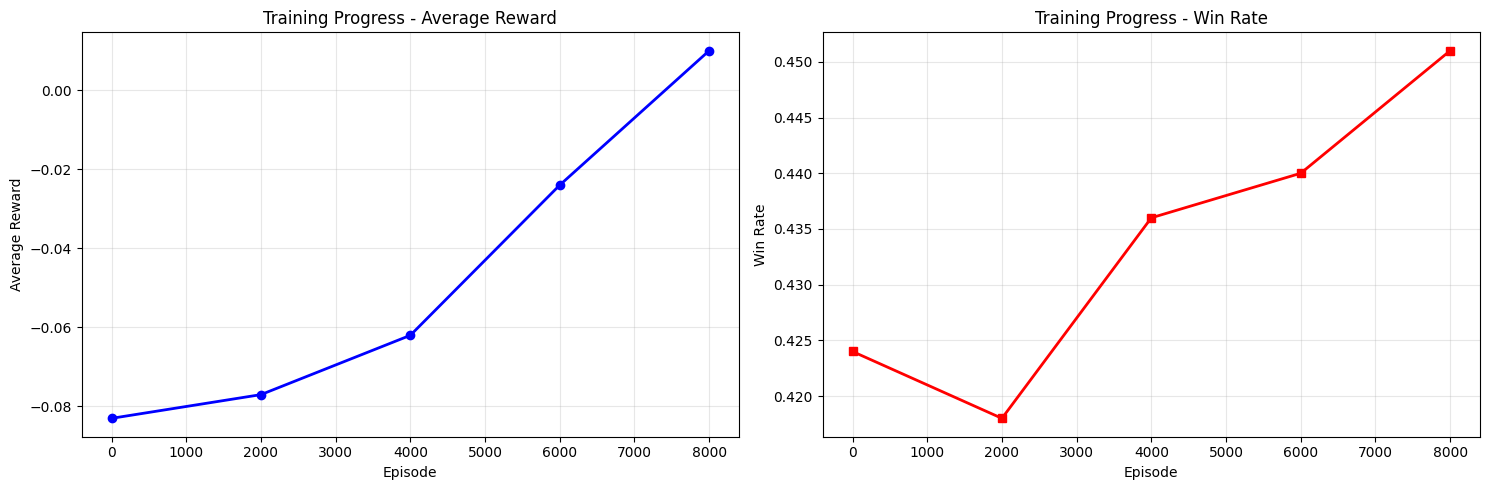

Training progress plotted!

Hyperparameter tuning complete!


In [13]:
if 'training_history' in locals() and training_history:
    episodes, rewards, win_rates = zip(*training_history)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot average rewards
    ax1.plot(episodes, rewards, 'b-', linewidth=2, marker='o')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Average Reward')
    ax1.set_title('Training Progress - Average Reward')
    ax1.grid(True, alpha=0.3)
    
    # Plot win rates
    ax2.plot(episodes, win_rates, 'r-', linewidth=2, marker='s')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Win Rate')
    ax2.set_title('Training Progress - Win Rate')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print("Training progress plotted!")

print("\nHyperparameter tuning complete!")


In [ ]:
# Save the final model
torch.save(final_agent.q_estimator.qnet.state_dict(), 'final_model.pth')
